In [29]:
import requests
import json
import pandas as pd
import numpy as np
import logging
import sys
import time
from tqdm.notebook import tqdm
import pickle
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import swifter
import uuid
from dateutil.relativedelta import relativedelta

In [30]:
# '''
# project	The name of the project
# street	The street name that the project is on.
# marketSegment	The market segment that the property falls in.
# CCR – Core Central Region
# RCR – Rest of Central Region
# OCR – Outside Central Region
# x	The x coordinates of the address of the property in SVY21 format. Important: This is the location of the property and does not represent the location of the transacted unit.
# y	The y coordinates of the address of the property in SVY21 format. Important: This is the location of the property and does not represent the location of the transacted unit.
# transaction	An array of transactions for this property
#     propertyType	The property type of the transacted property. Note that there are properties with a mixture of property types.
# Strata Detached
# Strata Semidetached
# Strata Terrace
# Detached
# Semi-detached
# Terrace
# Apartment
# Condominium
# Executive Condominium
#     district	The postal district that the transacted property falls in. Note that there are properties that fall across multiple postal district.
#     tenure	The tenure of the transacted property. Note that there are properties that have units with multiple tenures.
# Freehold
# xx yrs lease commencing from yyyy
#     typeOfSale	The type of sale
# 1 – New Sale
# 2 – Sub Sale
# 3 – Resale
#     noOfUnits	The number of units in this transaction. The value for New Sale will always be 1. The value for Resale or Sub Sale could be greater than 1 depending on the number of units lodged for the caveat.
#     price	The transacted price nettPrice
#     nettPrice	The nett transacted price, excluding discounts if any. This field is only applicable for New Sale where discounts were given.
#     area	The land/floor area of the transacted unit in square metre.
#     typeOfArea	The type of area of the transacted unit.
# Strata
# Land
# Unknown
#     floorRange	The floor range that the transacted unit falls within.
# -
# B1-B5
# B6-B10
# 01-05
# 06-10
# ...
#     contractDate	The data of sale for New Sale records or option exercised date for Resale and Sub Sale records. Field is in format of mmyy e.g. 1215 represents Dec 2015.

# '''

### Data Preprocessing

In [31]:
transactions_master_agg = pd.read_csv('transaction_master_agg.csv')
transactions_raw = pd.read_csv('transactions_raw.csv')

In [32]:
# geocode table
file = open("geocode.obj",'rb')
geocoded = pickle.load(file)
# geocoded.to_csv('properties_geocoded.csv.gz', index=False)
geocoded = geocoded.dropna()
geocoded['lat'] = geocoded['lat_lng'].apply(lambda x: x.split(', ')[0])
geocoded['lng'] = geocoded['lat_lng'].apply(lambda x: x.split(', ')[1])

In [33]:
transactions_raw.head()

,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,street,project,marketSegment,nettPrice
0,524.3,-,1,2020-02-01,3,5500000,Semi-detached,5,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,RCR,NaN
1,308.0,-,1,2018-09-01,3,5000000,Semi-detached,5,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,RCR,NaN
2,314.0,-,1,2018-06-01,3,4750000,Semi-detached,5,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,RCR,NaN
3,308.0,-,1,2021-09-01,3,5200000,Semi-detached,5,Land,Freehold,ZEHNDER ROAD,LANDED HOUSING DEVELOPMENT,RCR,NaN
4,159.3,-,1,2020-03-01,3,2630000,Terrace,5,Land,Freehold,NEO PEE TECK LANE,LANDED HOUSING DEVELOPMENT,RCR,NaN


In [34]:
# properties table
id_cols = list(transactions_raw.columns)
id_cols = [col for col in transactions_raw.columns if col not in ['price', 'nettPrice', 'contractDate', 'noOfUnits']]
properties = transactions_raw[id_cols].drop_duplicates().reset_index(drop=True)
properties['property_key'] = properties.apply(lambda x: 'p-'+uuid.uuid4().hex[:9], axis=1)

In [40]:
# bring everything together
transactions_master_agg_clean = transactions_master_agg.merge(geocoded[['street', 'project', 'lat', 'lng']], on=['street', 'project'], how='left')
transactions_master_agg_clean = transactions_master_agg_clean.merge(properties, on=id_cols, how='left')


col_orders = \
['property_key', 'street', 'project', 'marketSegment', 
 'area', 'floorRange', 'contractDate', 'typeOfSale', 'propertyType',
 'district', 'typeOfArea', 'tenure', 'median_price', 'lat', 'lng', ]


transactions_master_agg_clean = transactions_master_agg_clean[col_orders]
transactions_master_agg_clean.rename({'median_price':'price'}, axis=1, inplace=True)

transactions_master_agg_clean['contractDate'] = pd.to_datetime(transactions_master_agg_clean['contractDate'])
transactions_master_agg_clean['contractDate'] = transactions_master_agg_clean['contractDate'].apply(lambda x: x.date())
transactions_master_agg_clean = transactions_master_agg_clean.sort_values(by='contractDate').reset_index(drop=True)


In [41]:
transactions_master_agg_clean.shape

(96684, 15)

In [45]:
transactions_master_agg_clean = transactions_master_agg_clean.drop_duplicates(subset=['contractDate'] + id_cols)

In [72]:
# rent_master_pivoted = rent_master_agg_clean.pivot_table(index='property_key', columns='leaseDate', values='rental_price')

In [128]:
def historical_mean(rent_master_pivoted, property_key:str, ref_date:datetime.date, time_window:int, offset:int):
    df = rent_master_pivoted[rent_master_pivoted.index==property_key]
    ref_date = ref_date - relativedelta(months=offset)
    date_ranges = [col for col in df.columns if col < ref_date and col >= ref_date-relativedelta(months=time_window)]
#     historical_mean = df.loc[(df['leaseDate']>=ref_date-relativedelta(months=time_window)) 
#                              & (df['leaseDate']<ref_date), 'rental_price'].mean()

#     df[date_ranges].mean(axis=0)
    return df[date_ranges].mean(axis=1).values[0]
    

In [143]:
past_6_months_mean = \
train_ids.swifter.apply(lambda x: historical_mean(rent_master_pivoted, property_key=x['property_key'], 
                                                  ref_date=x['leaseDate'], time_window=6, offset=0), axis=1)

In [144]:
past_6_months_offset1_mean = \
train_ids.swifter.apply(lambda x: historical_mean(rent_master_pivoted, property_key=x['property_key'], 
                                                  ref_date=x['leaseDate'], time_window=6, offset=1), axis=1)

In [ ]:
past_6_months_offset2_mean = \
train_ids.swifter.apply(lambda x: historical_mean(rent_master_pivoted, property_key=x['property_key'], 
                                                  ref_date=x['leaseDate'], time_window=6, offset=2), axis=1)

In [ ]:
# past 6 months rent mean

def historical_mean(rent_master, property_key:str, ref_date:datetime.date, time_window:int, offset:int):
    df = rent_master[rent_master['property_key']==property_key]
    ref_date = ref_date - relativedelta(months=offset)    
    historical_mean = df.loc[(df['leaseDate']>=ref_date-relativedelta(months=time_window)) & (df['leaseDate']<ref_date), 'rental_price'].mean()
    
    return historical_mean
    
    
def calc_historical_mean(df, rent_master, time_window, offset):
    past_6_months_mean = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        past_6_months_mean.append(historical_mean(rent_master, row['property_key'], row['leaseDate'], time_window, offset))

    df['past_6_months_mean'] = past_6_months_mean
    
    return df

# train
X_train = calc_historical_mean(X_train, rent_master_agg_clean, 6, 0)

# test
X_test_december = calc_historical_mean(X_test_december, rent_master_agg_clean, 6, 0)


In [46]:
transactions_master_agg_clean.head()

,property_key,street,project,marketSegment,area,floorRange,contractDate,typeOfSale,propertyType,district,typeOfArea,tenure,price,lat,lng
0,p-fd9e4646c,HAIG ROAD,HAIG COURT,RCR,100.0,01-05,2018-03-01,3,Condominium,15,Strata,Freehold,1430000.0,1.30656471420158,103.898292204928
1,p-b221576e3,PASIR RIS LINK,SEA ESTA,OCR,128.0,01-05,2018-03-01,3,Condominium,18,Strata,99 yrs lease commencing from 2012,1300000.0,1.37742779265615,103.959877225877
2,p-fc49b5b86,WEST COAST PARK,BOTANNIA,OCR,144.0,01-05,2018-03-01,3,Condominium,5,Strata,956 yrs lease commencing from 1928,1850000.0,1.31803357100435,103.753527872969
3,p-34a4d1ddb,HOUGANG STREET 11,THE MINTON,OCR,154.0,11-15,2018-03-01,3,Condominium,19,Strata,99 yrs lease commencing from 2007,1850000.0,1.3513904432788,103.881242080921
4,p-be5c2743f,WESTWOOD WALK,WESTVILLE,OCR,159.7,-,2018-03-01,3,Terrace,22,Land,99 yrs lease commencing from 1994,1250000.0,1.35306411051944,103.697961431183


In [47]:
# train test split
train = transactions_master_agg_clean[transactions_master_agg_clean['contractDate']<datetime.date(2023,1,1)]
test = transactions_master_agg_clean[transactions_master_agg_clean['contractDate']>=datetime.date(2023,1,1)]

# split x and y
train_ids = train[['property_key', 'contractDate', 'price']]
test_ids = test[['property_key', 'contractDate']]
y_test = test.set_index(['property_key', 'contractDate'])['price']

In [23]:
geocoded = geocoded.drop(['key', 'lat_lng'], axis=1)

In [15]:
# import os
# os.mkdir('transactions_final_data')

In [48]:
geocoded.to_csv('transactions_final_data/geocodes.csv', index=False)
properties.to_csv('transactions_final_data/properties.csv', index=False)
train_ids.to_csv('transactions_final_data/train.csv', index=False)
test_ids.to_csv('transactions_final_data/test.csv', index=False)
y_test.to_csv('transactions_final_data/test_target.csv')

In [52]:
y_test

property_key  contractDate
p-745f708bd   2023-01-01      2583000.0
p-a45c69849   2023-01-01      1260000.0
p-8e4313761   2023-01-01      1974849.0
p-e21a76721   2023-01-01      1425000.0
p-656fb7cad   2023-01-01      2217000.0
                                ...    
p-91df4494a   2023-03-01       900000.0
p-4528d744a   2023-03-01      5150000.0
p-a9e01583d   2023-03-01       688000.0
p-3c90d50ce   2023-03-01      1633862.0
p-c1c1ac44e   2023-03-01      1065000.0
Name: price, Length: 3245, dtype: float64

In [484]:
submission = test_ids.copy()
submission['prediction'] = 5000

In [489]:
submission.head(500).to_csv('final_data/sample_submission/sample_submission_dummy.csv', index=False)

In [25]:
test_ids.shape

(12954, 2)

In [439]:
X_train = train_ids.drop('rental_price', axis=1)
y_train = train_ids['rental_price']

X_test_december = test_ids[test_ids['leaseDate']==datetime.date(2022,12,1)]
y_test_december = X_test_december.set_index(['property_key', 'leaseDate']).join(y_test, how='left')

In [67]:
# def target_calculator(rent_master_agg, n):
#     prices = []
#     for index, row in tqdm(rent_master_agg.iterrows(), total=rent_master_agg.shape[0]):
#         leaseDate = row['leaseDate'] + relativedelta(months=1)
#         property_key = row['property_key']

#         filtered = \
#         rent_master_agg[(rent_master_agg['leaseDate']==leaseDate) & 
#                               (rent_master_agg['property_key']==property_key)]

#         if filtered.shape[0] == 0:
#             rental_price = np.nan
#         else:    
#             rental_price = filtered['rental_price'].values[0]

#         prices.append(rental_price)  
        
#     return prices

In [68]:
# n_2 = target_calculator(rent_master_agg_clean, 1)

In [69]:
# n = 1

# prices = []
# for index, row in tqdm(rent_master_agg_clean.sample(50).iterrows(), total=rent_master_agg_clean.head().shape[0]):
#     leaseDate = row['leaseDate'] + relativedelta(months=1)
#     property_key = row['property_key']
    
#     filtered = \
#     rent_master_agg_clean[(rent_master_agg_clean['leaseDate']==leaseDate) & 
#                           (rent_master_agg_clean['property_key']==property_key)]
    
#     if filtered.shape[0] == 0:
#         rental_price = np.nan
#     else:    
#         rental_price = filtered['rental_price'].values[0]
    
#     prices.append(rental_price)

In [440]:
# past 6 months rent mean

def historical_mean(rent_master, property_key:str, ref_date:datetime.date, time_window:int, offset:int):
    df = rent_master[rent_master['property_key']==property_key]
    ref_date = ref_date - relativedelta(months=offset)    
    historical_mean = df.loc[(df['leaseDate']>=ref_date-relativedelta(months=time_window)) & (df['leaseDate']<ref_date), 'rental_price'].mean()
    
    return historical_mean
    
    
def calc_historical_mean(df, rent_master, time_window, offset):
    past_6_months_mean = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        past_6_months_mean.append(historical_mean(rent_master, row['property_key'], row['leaseDate'], time_window, offset))

    df['past_6_months_mean'] = past_6_months_mean
    
    return df

# train
X_train = calc_historical_mean(X_train, rent_master_agg_clean, 6, 0)

# test
X_test_december = calc_historical_mean(X_test_december, rent_master_agg_clean, 6, 0)


  0%|          | 0/231394 [00:00<?, ?it/s]

  0%|          | 0/4550 [00:00<?, ?it/s]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [441]:
# areaSqm 
def encode_areaSqm(df):
    areaSqm = pd.get_dummies(properties.set_index('property_key')['areaSqm'])
    areaSqm.columns = ['areaSqm_'+col for col in areaSqm.columns]
    df = df.merge(areaSqm.reset_index(), on='property_key', how='left')
    
    return df

# train
X_train = encode_areaSqm(X_train)

# test
X_test_december = encode_areaSqm(X_test_december)

In [442]:
# noOfBedRoom

# train
X_train = X_train.merge(properties[['property_key', 'noOfBedRoom']], on='property_key', how='left')
X_train['noOfBedRoom'] = X_train['noOfBedRoom'].fillna(0)

# test
X_test_december = X_test_december.merge(properties[['property_key', 'noOfBedRoom']], on='property_key', how='left')
X_test_december['noOfBedRoom'] = X_test_december['noOfBedRoom'].fillna(0)

In [443]:
# fill missing values for past 6 months mean by median rent price by bedroom

# train
train['noOfBedRoom'] = train['noOfBedRoom'].fillna(0)
rent_median_by_bedroom = train.groupby('noOfBedRoom')['rental_price'].median().to_dict()

X_train['past_6_months_mean'] = \
X_train.apply(lambda x: x['past_6_months_mean'] if x['past_6_months_mean']==x['past_6_months_mean'] \
              else rent_median_by_bedroom[x['noOfBedRoom']], axis=1)

# test
X_test_december['past_6_months_mean'] = \
X_test_december.apply(lambda x: x['past_6_months_mean'] if x['past_6_months_mean']==x['past_6_months_mean'] \
                      else rent_median_by_bedroom[x['noOfBedRoom']], axis=1)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [444]:
# district

# train
X_train = X_train.merge(properties[['property_key', 'district']], on='property_key', how='left')

# test
X_test_december = X_test_december.merge(properties[['property_key', 'district']], on='property_key', how='left')

In [448]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [454]:
X_train = X_train.set_index(['property_key', 'leaseDate'])
X_test_december = X_test_december.set_index(['property_key', 'leaseDate'])

In [457]:
lgb_train = lgb.Dataset(X_train, y_train)

In [458]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [459]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                verbose_eval=100)

In [467]:
y_pred = y_test_december.copy()
y_pred['y_pred'] = gbm.predict(X_test_december)

In [471]:
y_pred.head()

,,rental_price,y_pred
property_key,leaseDate,,
p-9fc9988bc,2022-12-01,3500.0,4301.545914
p-02983bc11,2022-12-01,6500.0,5593.144007
p-781bcdb7f,2022-12-01,5900.0,5085.818268
p-1131ed095,2022-12-01,6650.0,8032.591267
p-47d51f8ee,2022-12-01,5000.0,4723.212011


In [473]:
mean_squared_error(y_true=y_pred['rental_price'], y_pred=y_pred['y_pred'])**(1/2)

2742.0420775542125

In [491]:
import os

In [492]:
os.mkdir('model_data')

In [493]:
X_train.to_csv('model_data/X_train.csv')
y_train.to_csv('model_data/y_train.csv')
X_test_december.to_csv('model_data/X_test_december.csv')
y_test_december.to_csv('model_data/y_test_december.csv')

In [466]:
len(gbm.predict(X_test_december))

4550

In [462]:
pd.DataFrame({'y':y_test_december , 'y_pred': gbm.predict(X_test_december)})

ValueError: Shape of passed values is (1, 2), indices imply (4550, 2)

In [119]:
from dateutil.relativedelta import relativedelta

In [120]:
rent_master_agg_geo['leaseDate'] = pd.to_datetime(rent_master_agg_geo['leaseDate'])

In [127]:
rent_master_agg_geo['key'] = rent_master_agg_geo.apply(lambda x: x['areaSqm'] + x['street'] + x['project'] + str(x['noOfBedRoom']) + str(x['district']), axis=1)

In [128]:
rent_master_agg_geo_2022 = rent_master_agg_geo[rent_master_agg_geo['leaseDate'].apply(lambda x: x.year)>=2022]

In [130]:
price_diff = []
for index, row in tqdm(rent_master_agg_geo_2022.iterrows(), total=rent_master_agg_geo_2022.shape[0]):
    prev_leaseDate = pd.to_datetime(row['leaseDate']) - relativedelta(years=1)
    prev_price = rent_master_agg_geo.loc[(rent_master_agg_geo['key']==row['key']) & \
                                         (rent_master_agg_geo['leaseDate']==prev_leaseDate), 'median']
    if prev_price.shape[0] == 0:
        price_diff.append(np.nan)
    else:
        
        price_diff.append((row['median'] - prev_price.values[0])/prev_price.values[0])

In [131]:
rent_master_agg_geo_2022['price_change'] = price_diff

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [199]:
rent_master_agg_geo_2022[rent_master_agg_geo_2022['leaseDate']>='2023-02-01'].groupby(['district'])['price_change'].median().sort_values().dropna()


district
6    -0.045455
25    0.250000
26    0.280000
4     0.301525
9     0.305556
11    0.306452
15    0.314286
8     0.321429
20    0.328125
12    0.328571
10    0.329545
19    0.333333
7     0.333333
16    0.333333
22    0.346667
14    0.346939
2     0.351346
1     0.353448
13    0.360000
5     0.363636
21    0.368421
23    0.369177
27    0.370968
17    0.375000
28    0.389627
3     0.392857
18    0.396552
Name: price_change, dtype: float64

<AxesSubplot:xlabel='district', ylabel='price_change'>

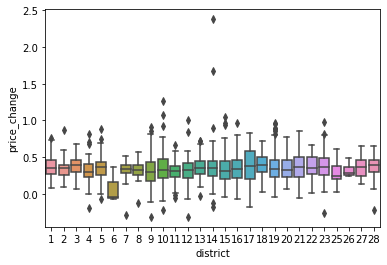

In [202]:
sns.boxplot(rent_master_agg_geo_2022[rent_master_agg_geo_2022['leaseDate']>='2023-02-01'], x='district', y='price_change')

In [205]:
# n = 1
districts = [27, 17, 28]

# projects = ['RIVIERA 38', 'SOPHIA 98', 'SPACE @ KOVAN', 'CENTRA RESIDENCE',
#             'TWIN WATERFALLS', 'CHARLESTON', 'LAVERNE\'S LOFT', 'ST FRANCIS COURT',
#             'LOTUS AT PAYA LEBAR (EAST WING)', 'THE DRAYCOTT']

# target_column = 'price_change'
# filtered_df = rent_master_agg_geo_2022[rent_master_agg_geo_2022['noOfBedRoom']==n]
filtered_df = rent_master_agg_geo_2022.copy().dropna(subset=[target_column])
filtered_df = filtered_df[filtered_df['district'].isin(districts)]
# filtered_df = filtered_df[filtered_df['project'].isin(projects)]
filtered_df = filtered_df.sort_values(by='leaseDate')
px.scatter_mapbox(
    filtered_df,
    lat="lat",
    lon="lng",
    color=target_column,
    range_color=[filtered_df[target_column].quantile(0.01), filtered_df[target_column].quantile(0.99)],
    hover_data=["project"],
    animation_frame="leaseDateStr",
).update_layout(
    mapbox={"style": "carto-positron", "zoom":11}, margin={"l": 0, "r": 0, "t": 0, "b": 0})


In [190]:
# n = 2
# target_column = 'price_change'
# filtered_df = rent_master_agg_geo_2022[rent_master_agg_geo_2022['noOfBedRoom']==n].dropna(subset=[target_column])
# px.scaatter_mapbox(
#     filtered_df,
#     lat="lat",
#     lon="lng",
#     color=target_column,
#     range_color=[filtered_df[target_column].quantile(0.01), filtered_df[target_column].quantile(0.99)],
#     hover_data=["project"],
#     animation_frame="leaseDateStr",
# ).update_layout(
#     mapbox={"style": "carto-positron", "zoom":11}, margin={"l": 0, "r": 0, "t": 0, "b": 0})


In [21]:
import sparkbeyond._api2.classes as sb
base_url = 'https://demo.sparkbeyond.com'
api_key = 'eyJhbGciOiJIUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICI3YzE2YmVjYy1lZjQ0LTQ2NjYtOGI4Ni0xMDVmZWQ3ZGVlOTkifQ.eyJpYXQiOjE2NzYyMTA3MjYsImp0aSI6Ijg2MjZjMDU3LTRkOTEtNGI4ZC1iMzUyLTlkN2RiYmM5MDk0MCIsImlzcyI6Imh0dHBzOi8vZGVtby5zcGFya2JleW9uZC5jb20vYXV0aC9yZWFsbXMvc3BhcmtiZXlvbmQiLCJhdWQiOiJodHRwczovL2RlbW8uc3BhcmtiZXlvbmQuY29tL2F1dGgvcmVhbG1zL3NwYXJrYmV5b25kIiwic3ViIjoiMTkxMzFhZWYtYWMxNi00MjYwLTgzMWEtNDMzMWI4YTVmZjRmIiwidHlwIjoiT2ZmbGluZSIsImF6cCI6ImRpc2NvdmVyeS1zZGsiLCJzZXNzaW9uX3N0YXRlIjoiNDRmNDViZTctM2YyYi00OTZiLThhNTMtYzA2ZWMzYzM1MjhkIiwic2NvcGUiOiJwcm9maWxlIGVtYWlsIG9mZmxpbmVfYWNjZXNzIiwic2lkIjoiNDRmNDViZTctM2YyYi00OTZiLThhNTMtYzA2ZWMzYzM1MjhkIn0.3tZERcflDYAO-109T3_69yVffMaDW0k6kZLrZF7jpEg'

client = sb.SparkBeyondClient(base_url = base_url,
                              api_key=api_key,
                              verify_ssl_certificate=False)

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



In [24]:
rent_master_agg_geo['leaseDate'].describe()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  220716
unique                     60
top       2023-01-01 00:00:00
freq                     4638
first     2018-03-01 00:00:00
last      2023-02-01 00:00:00
Name: leaseDate, dtype: object

In [192]:
np.log(rent_master_agg_geo['median']).mean()

8.17333117897995

In [27]:
rent_master_agg_geo

,areaSqm,leaseDate,propertyType,district,areaSqft,noOfBedRoom,street,project,min,mean,median,max,lat,lng,leaseDateStr,key
0,100-110,2018-03-01,Executive Condominium,18,1100-1200,3.0,PASIR RIS STREET 72,WHITEWATER,2350,2416.666667,2400.0,2500,1.379936,103.935495,2018-03-01,100-110181100-12003.0PASIR RIS STREET 72WHITEW...
1,100-110,2018-03-01,Executive Condominium,22,1000-1100,3.0,JURONG EAST STREET 13,WESTMERE,2700,2700.000000,2700.0,2700,1.337585,103.736683,2018-03-01,100-110221000-11003.0JURONG EAST STREET 13WEST...
2,100-110,2018-03-01,Executive Condominium,25,1100-1200,3.0,WOODLANDS DRIVE 16,LA CASA,2400,2450.000000,2450.0,2500,1.431887,103.797921,2018-03-01,100-110251100-12003.0WOODLANDS DRIVE 16LA CASA
3,100-110,2018-03-01,Executive Condominium,27,1100-1200,3.0,YISHUN AVENUE 6,LILYDALE,2450,2450.000000,2450.0,2450,1.423928,103.849332,2018-03-01,100-110271100-12003.0YISHUN AVENUE 6LILYDALE
4,100-110,2018-03-01,Non-landed Properties,1,1000-1100,2.0,SHENTON WAY,ONE SHENTON,4850,4850.000000,4850.0,4850,1.279295,103.850553,2018-03-01,100-11011000-11002.0SHENTON WAYONE SHENTON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220711,>800,2023-01-01,Detached House,11,>8000,NaN,ASH GROVE,RAFFLES PARK,12000,12000.000000,12000.0,12000,1.333565,103.802383,2023-01-01,>80011>8000nanASH GROVERAFFLES PARK
220712,>800,2023-02-01,Detached House,10,>8000,NaN,LEEDON PARK,LANDED HOUSING DEVELOPMENT,42000,42000.000000,42000.0,42000,1.316460,103.796056,2023-02-01,>80010>8000nanLEEDON PARKLANDED HOUSING DEVELO...
220713,>800,2023-02-01,Detached House,10,>8000,NaN,QUEEN ASTRID PARK,LANDED HOUSING DEVELOPMENT,35000,35000.000000,35000.0,35000,1.317969,103.790369,2023-02-01,>80010>8000nanQUEEN ASTRID PARKLANDED HOUSING ...
220714,>800,2023-02-01,Detached House,11,>8000,NaN,BUKIT TUNGGAL ROAD,LANDED HOUSING DEVELOPMENT,29750,29750.000000,29750.0,29750,1.321244,103.838957,2023-02-01,>80011>8000nanBUKIT TUNGGAL ROADLANDED HOUSING...


In [28]:
rent_master_agg_geo['unique_property_key'] = rent_master_agg_geo.apply(lambda x: x['areaSqm'] + x['street'] + x['project'], axis=1)

In [31]:
rent_master_agg_geo_clean  = rent_master_agg_geo.drop(['key', 'leaseDateStr', 'min', 'mean', 'max'], axis=1)

In [76]:
rent_master_agg_geo_clean = rent_master_agg_geo_clean.rename({'lng':'lon'}, axis=1)

In [77]:
project_name = 'singapore_rent'

In [79]:
client.upload_dataframe(rent_master_agg_geo_clean, project_name=project_name, target_path = 'rent_master_clean.csv.gz', append_contents_hash=False)

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



Uploading: 100%|██████████| 7.08M/7.08M [00:09<00:00, 711kB/s]


TabularInput(
    name="rent_master_clean.csv.gz",
    source=FormattedSource(
        source=LocalFileSource(location=FileReference(
            location=<FileReferenceLocation.Project: 'Project'>,
            path="rent_master_clean.csv.gz",
            project_name="singapore_rent",
            
        )),
        settings=StreamParsingSettings(
            compression=GzipCompression,
            encoding="UTF-8",
            format=DelimitedStreamFormat(separator='\t')
        )
    )
)

In [177]:
model = client.revision(project_name=project_name, revision_id=4)

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



In [206]:
pred = model.predict(sb.PredictParams(inputs=[rent_master_agg_geo_clean], include_originals=True)).results_dataframe()

Hashing dataframe contents: 100%|██████████| 220716/220716 [00:00<00:00, 957458.14 rows/s]
/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usag

Rows processed: 80000 [00:22, 3488.70 rows/s]/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

Rows processed: 84800 [00:24, 3574.92 rows/s]/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

Rows processed: 88000 [00:25, 3178.31 rows/s]/usr/local/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'demo.sparkbeyond.com'. Adding certificate verification is strongly advised. See: https://ur

In [208]:
pred

,areaSqm,leaseDate,propertyType,district,areaSqft,noOfBedRoom,street,project,median,unique_property_key,latLong,last 1 years by project ID-cac3,last 12 weeks by project ID-f85f,last 1 years by district ID-72c5,last 12 weeks by district ID-99cc,last 1 years by unique_property_key ID-0849,last 12 weeks by unique_property_key ID-30bf,median_predicted
0,"Segment(100.0,110.0)",Thu Mar 01 00:00:00 UTC 2018,"""Executive Condominium""",18,"Segment(1100.0,1200.0)",3.0,"""PASIR RIS STREET 72""","""WHITEWATER""",2400.0,"""100-110PASIR RIS STREET 72WHITEWATER""","1.37993635799156, 103.935495173706","KeyedTimeWindow(key=WHITEWATER, startDate=01/0...","KeyedTimeWindow(key=WHITEWATER, startDate=07/1...","KeyedTimeWindow(key=18, startDate=01/03/17 12:...","KeyedTimeWindow(key=18, startDate=07/12/17 12:...",KeyedTimeWindow(key=100-110PASIR RIS STREET 72...,KeyedTimeWindow(key=100-110PASIR RIS STREET 72...,2756.423827
1,"Segment(100.0,110.0)",Thu Mar 01 00:00:00 UTC 2018,"""Executive Condominium""",22,"Segment(1000.0,1100.0)",3.0,"""JURONG EAST STREET 13""","""WESTMERE""",2700.0,"""100-110JURONG EAST STREET 13WESTMERE""","1.33758505557106, 103.736682684179","KeyedTimeWindow(key=WESTMERE, startDate=01/03/...","KeyedTimeWindow(key=WESTMERE, startDate=07/12/...","KeyedTimeWindow(key=22, startDate=01/03/17 12:...","KeyedTimeWindow(key=22, startDate=07/12/17 12:...",KeyedTimeWindow(key=100-110JURONG EAST STREET ...,KeyedTimeWindow(key=100-110JURONG EAST STREET ...,2756.423827
2,"Segment(100.0,110.0)",Thu Mar 01 00:00:00 UTC 2018,"""Executive Condominium""",25,"Segment(1100.0,1200.0)",3.0,"""WOODLANDS DRIVE 16""","""LA CASA""",2450.0,"""100-110WOODLANDS DRIVE 16LA CASA""","1.43188746099951, 103.797920739127","KeyedTimeWindow(key=LA CASA, startDate=01/03/1...","KeyedTimeWindow(key=LA CASA, startDate=07/12/1...","KeyedTimeWindow(key=25, startDate=01/03/17 12:...","KeyedTimeWindow(key=25, startDate=07/12/17 12:...",KeyedTimeWindow(key=100-110WOODLANDS DRIVE 16L...,KeyedTimeWindow(key=100-110WOODLANDS DRIVE 16L...,2756.423827
3,"Segment(100.0,110.0)",Thu Mar 01 00:00:00 UTC 2018,"""Executive Condominium""",27,"Segment(1100.0,1200.0)",3.0,"""YISHUN AVENUE 6""","""LILYDALE""",2450.0,"""100-110YISHUN AVENUE 6LILYDALE""","1.4239283710886599, 103.849332055297","KeyedTimeWindow(key=LILYDALE, startDate=01/03/...","KeyedTimeWindow(key=LILYDALE, startDate=07/12/...","KeyedTimeWindow(key=27, startDate=01/03/17 12:...","KeyedTimeWindow(key=27, startDate=07/12/17 12:...",KeyedTimeWindow(key=100-110YISHUN AVENUE 6LILY...,KeyedTimeWindow(key=100-110YISHUN AVENUE 6LILY...,2566.163202
4,"Segment(100.0,110.0)",Thu Mar 01 00:00:00 UTC 2018,"""Non-landed Properties""",1,"Segment(1000.0,1100.0)",2.0,"""SHENTON WAY""","""ONE SHENTON""",4850.0,"""100-110SHENTON WAYONE SHENTON""","1.27929478959373, 103.850552555075","KeyedTimeWindow(key=ONE SHENTON, startDate=01/...","KeyedTimeWindow(key=ONE SHENTON, startDate=07/...","KeyedTimeWindow(key=1, startDate=01/03/17 12:0...","KeyedTimeWindow(key=1, startDate=07/12/17 12:0...",KeyedTimeWindow(key=100-110SHENTON WAYONE SHEN...,KeyedTimeWindow(key=100-110SHENTON WAYONE SHEN...,4449.393536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220711,"Segment(800.0,Infinity)",Sun Jan 01 00:00:00 UTC 2023,"""Detached House""",11,"Segment(8000.0,Infinity)",NaN,"""ASH GROVE""","""RAFFLES PARK""",12000.0,""">800ASH GROVERAFFLES PARK""","1.3335650513238, 103.802383498619","KeyedTimeWindow(key=RAFFLES PARK, startDate=01...","KeyedTimeWindow(key=RAFFLES PARK, startDate=09...","KeyedTimeWindow(key=11, startDate=01/01/22 12:...","KeyedTimeWindow(key=11, startDate=09/10/22 12:...","KeyedTimeWindow(key=>800ASH GROVERAFFLES PARK,...","KeyedTimeWindow(key=>800ASH GROVERAFFLES PARK,...",16776.226962
220712,"Segment(800.0,Infinity)",Wed Feb 01 00:00:00 UTC 2023,"""Detached House""",10,"Segment(8000.0,Infinity)",NaN,"""LEEDON PARK""","""LANDED HOUSING DEVELOPMENT""",42000.0,""">800LEEDON PARKLANDED HOUSING DEVELOPMENT""","1.3164600

In [194]:
rent_master_agg_geo['areaSqm'].nunique()

46